**Employee Attrition Analysis using Logistic Regression - Optimisation via permutations**

* Step 1 - Pre-process data

* Step 2 - Create Logistic Regression Model

* Step 3 - Evaluate the Model

* Step 4 - Calculate feature importance using permutations

* Step 5 - Optimise the Model

* Step 6 - Evaluate the Model, post optimisation

In [1]:
# Import dependencies
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# Import password
from passwords import postgres_password

In [2]:
# Establish the connection to postgres database
conn = psycopg2.connect(database = "project_4",
                        user = "postgres",
                        password = postgres_password,
                        host = "localhost",
                        port = "5432"
)

# Import and read the employee_attrition.csv from SQL
attrition_df = pd.read_sql_query('''SELECT * FROM attrition''', conn)

# Close the connection
conn.close()

C:\Users\danie\AppData\Local\Temp\ipykernel_14584\4226612750.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  attrition_df = pd.read_sql_query('''SELECT * FROM attrition''', conn)


In [3]:
# Review dataframe
attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,...,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Step 1 - Pre-process data

In [4]:
# Drop unnecessary and redundant columns
del attrition_df["employeecount"]
del attrition_df["employeenumber"]
del attrition_df["over18"]
del attrition_df["standardhours"]

attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [5]:
# Create a custum function to encode binary columns
def encode_column(column):
    if (column == "Yes") | (column == "Male"):
        return 1
    else:
        return 0

In [6]:
# Apply custom function to columns with boolean data
attrition_df["attrition"] = attrition_df["attrition"].apply(encode_column)
attrition_df["gender"] = attrition_df["gender"].apply(encode_column)
attrition_df["overtime"] = attrition_df["overtime"].apply(encode_column)
attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,3,4,1,6,3,3,2,2,2,2


In [7]:
# Encode categorical data to numeric with "pd.get_dummies"
converted_df = pd.get_dummies(attrition_df, columns=["businesstravel", "department", "educationfield", "jobrole", "maritalstatus"], dtype="int")
converted_df.head()

,age,attrition,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1,1102,1,2,2,0,94,3,2,...,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,3,1,61,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,4,1,92,2,1,...,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,4,0,56,3,1,...,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,1,40,3,1,...,1,0,0,0,0,0,0,0,1,0


Step 2 - Create a Logistic Regression Model

In [8]:
# Split our preprocessed data into our features and target arrays
y = converted_df["attrition"]
X = converted_df.drop(columns=["attrition"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)

In [9]:
# Review targets
pd.DataFrame(y).head()

,attrition
0,1
1,0
2,1
3,0
4,0


In [10]:
# Review features
X.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1102,1,2,2,0,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,1,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,1,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,0,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
4,27,591,2,1,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0


In [11]:
# Create logistic regerssion model
model = LogisticRegression(solver="lbfgs",
                                max_iter=200,
                                random_state=1)
model

LogisticRegression(max_iter=200, random_state=1)

In [12]:
# Fit training data to model
model.fit(X_train, y_train)

c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=1)

In [13]:
# Make predictions on testing data
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


Step 3 - Evaluate the Model

In [14]:
# Display the accuracy score for the test dataset.
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, predictions)}")

Logistic Regression Accuracy: 0.8288043478260869


In [15]:
# Print the classification report for the model
target_names = ["Attrition", "No Attrition"]
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

   Attrition       0.84      0.98      0.91       309
No Attrition       0.17      0.02      0.03        59

    accuracy                           0.83       368
   macro avg       0.50      0.50      0.47       368
weighted avg       0.73      0.83      0.77       368



In [16]:
# Generate the confusion matrix for the model
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix


array([[304,   5],
       [ 58,   1]], dtype=int64)

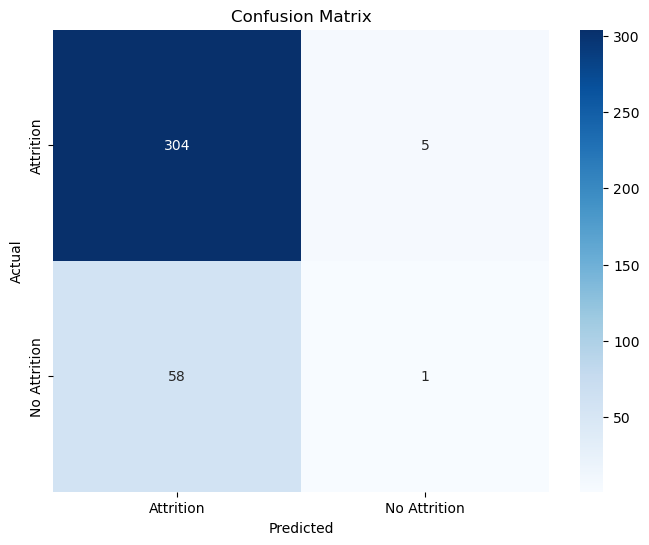

In [17]:
# Visualise the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Attrition", "No Attrition"], yticklabels=["Attrition", "No Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("output/confusion_matrix", bbox_inches = 'tight')
plt.show()

Step 4 - Calculate feature importance using permutations

In [18]:
# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=50, random_state=1)

# Feature importance DataFrame
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(perm_importance.importances_mean)})
perm_importance_df = perm_importance_df.loc[perm_importance_df["Importance"] >0,:]
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False).reset_index()

perm_importance_df.head()


,index,Feature,Importance
0,2,distancefromhome,0.009565
1,22,yearsincurrentrole,0.008533
2,24,yearswithcurrmanager,0.008478
3,12,numcompaniesworked,0.007989
4,10,monthlyincome,0.007772


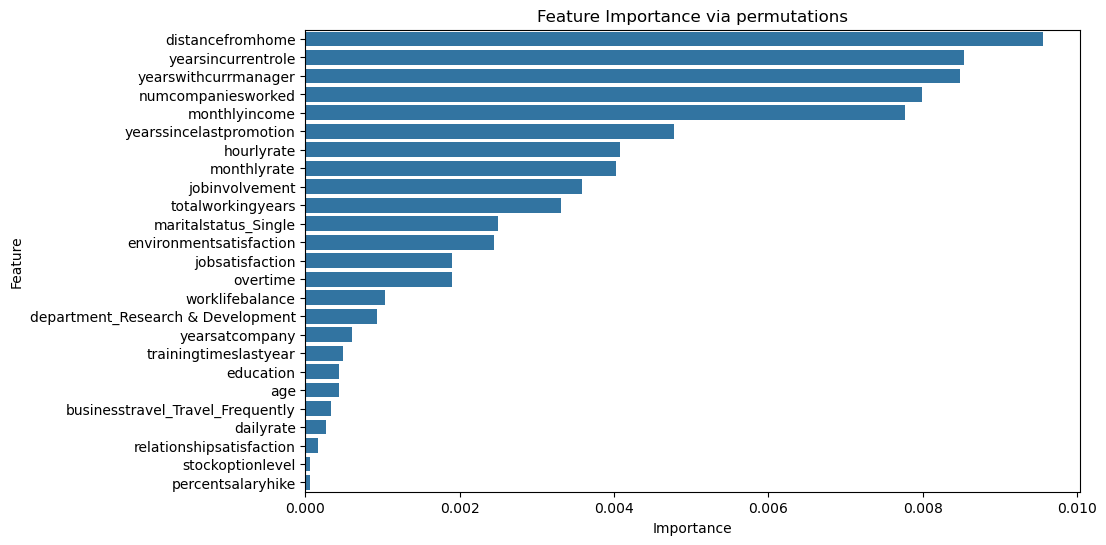

In [19]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title('Feature Importance via permutations')
plt.savefig("output/feature_importance_permutations", bbox_inches = 'tight')
plt.show()


Step 5 - Optimise the Model

In [20]:
# Use the 5 most important features
X_optimised = X[["distancefromhome", "yearsincurrentrole", "yearswithcurrmanager", "numcompaniesworked", "monthlyincome"]]

X_optimised.head()

,distancefromhome,yearsincurrentrole,yearswithcurrmanager,numcompaniesworked,monthlyincome
0,1,4,5,8,5993
1,8,7,7,1,5130
2,2,0,0,6,2090
3,3,7,0,1,2909
4,2,2,2,9,3468


In [21]:
# Use the 5 most important features
X_optimised = X[["distancefromhome", "yearsincurrentrole", "yearswithcurrmanager", "numcompaniesworked", "monthlyincome"]]

X_optimised.head()

,distancefromhome,yearsincurrentrole,yearswithcurrmanager,numcompaniesworked,monthlyincome
0,1,4,5,8,5993
1,8,7,7,1,5130
2,2,0,0,6,2090
3,3,7,0,1,2909
4,2,2,2,9,3468


In [22]:
# Fit the optimised data to the model
model.fit(X_train, y_train)

c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=1)

In [23]:
# Make predictions on testing data
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


Step 6 - Evaluate the Model, post optimisation

In [24]:
# Display the accuracy score for the test dataset.
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, predictions)}")

Logistic Regression Accuracy: 0.8288043478260869


In [25]:
# Print the classification report for the optimised model
target_names = ["Attrition", "No Attrition"]
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

   Attrition       0.84      0.98      0.91       309
No Attrition       0.17      0.02      0.03        59

    accuracy                           0.83       368
   macro avg       0.50      0.50      0.47       368
weighted avg       0.73      0.83      0.77       368



In [26]:
# Generate the confusion matrix for the optimised model
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[304,   5],
       [ 58,   1]], dtype=int64)

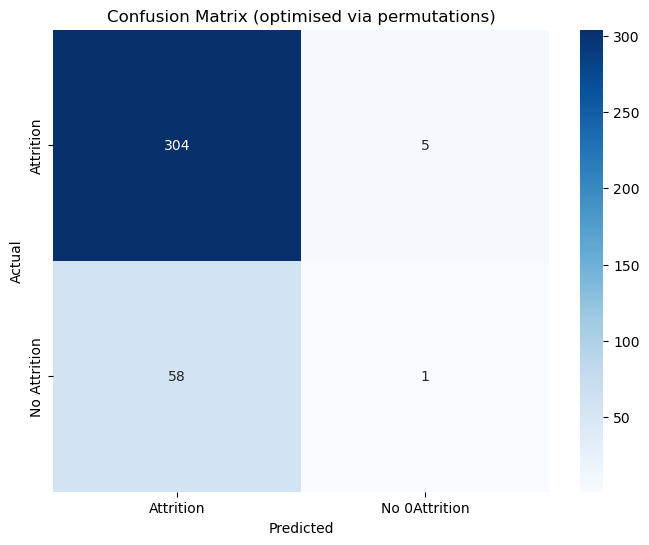

In [27]:
# Visualise the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Attrition", "No 0Attrition"], yticklabels=["Attrition", "No Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (optimised via permutations)")
plt.savefig("output/confusion_matrix_optimisation_permutations", bbox_inches = 'tight')
plt.show()